In [ ]:
!pip install -q tensorflow

In [ ]:
# Enable GPU memory growth to prevent OOM
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

In [ ]:
tf.config.list_physical_devices('GPU')
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 1


In [ ]:
!pip install -q plotly
import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

In [ ]:
tf.__version__

'2.18.0'

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
# 1) Install Kaggle’s CLI
!pip install -q kaggle

# 2) Upload your Kaggle API token:
#    – Go to https://www.kaggle.com/me/account → “Create New API Token” → Download kaggle.json
from google.colab import files
files.upload()   # select your kaggle.json when prompted

# 3) Move it into place and secure it
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4) Download and unzip the Deepfake Faces dataset
!kaggle datasets download -d dagnelies/deepfake-faces -q
!unzip -q deepfake-faces.zip -d deepfake-faces

# 5) Load metadata.csv into pandas
import pandas as pd
meta = pd.read_csv('deepfake-faces/metadata.csv')
meta.head()


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/dagnelies/deepfake-faces
License(s): other


,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [ ]:
meta.shape

(95634, 5)

In [ ]:
len(meta[meta.label=='FAKE']),len(meta[meta.label=='REAL'])

(79341, 16293)

In [ ]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 15000
fake_df = fake_df.sample(sample_size, random_state=42)
sample_meta = pd.concat([real_df, fake_df])

In [ ]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.15,random_state=42,stratify=Train_set['label'])

In [ ]:
Train_set.shape,Val_set.shape,Test_set.shape

((21278, 5), (3756, 5), (6259, 5))

In [ ]:
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)

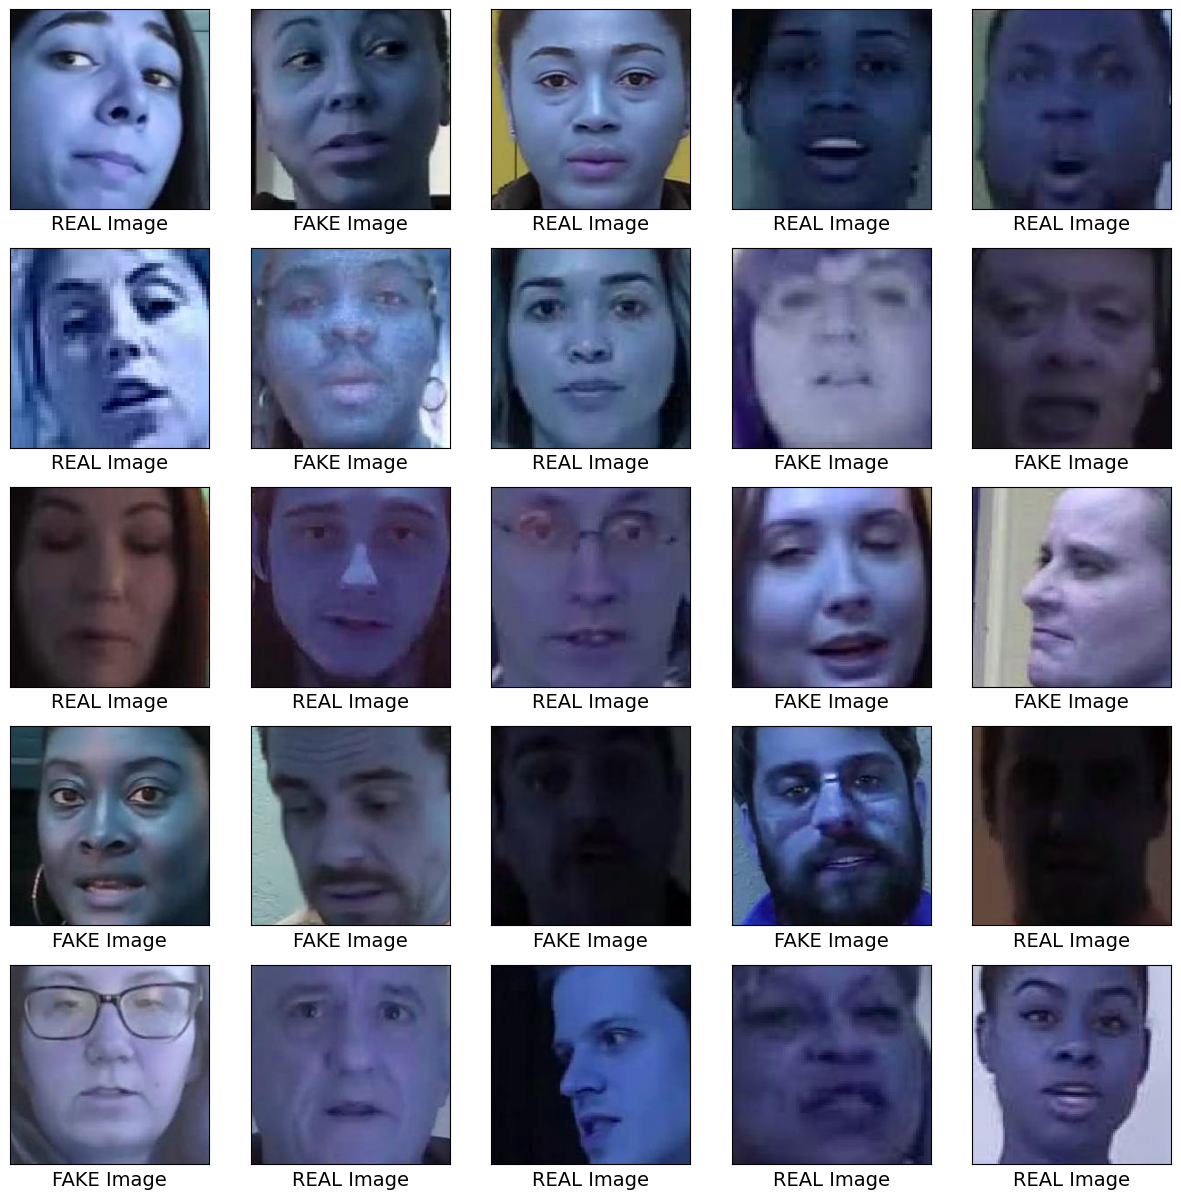

In [ ]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(cv2.imread('deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))

    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')

plt.show()

In [ ]:
import tensorflow as tf

# (If you haven’t already) Enable GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Build file‐path & label lists
train_paths = ['deepfake-faces/faces_224/' + f[:-4] + '.jpg' for f in Train_set['videoname']]
train_labels = [1 if lbl=='FAKE' else 0 for lbl in Train_set['label']]
val_paths   = ['deepfake-faces/faces_224/' + f[:-4] + '.jpg' for f in Val_set['videoname']]
val_labels  = [1 if lbl=='FAKE' else 0 for lbl in Val_set['label']]
test_paths  = ['deepfake-faces/faces_224/' + f[:-4] + '.jpg' for f in Test_set['videoname']]
test_labels = [1 if lbl=='FAKE' else 0 for lbl in Test_set['label']]

# Define preprocessing
IMG_SIZE = (224, 224)
def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

# Create tf.data pipelines
BATCH_SIZE = 4
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
      .shuffle(1000)
      .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
      .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)
test_ds = (
    tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
      .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)




In [ ]:

# --- Updated: State-of-the-art Xception-based model ---
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Initialize base model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False

# Build and compile model
inputs = Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Train and evaluate
history = model.fit(train_ds, validation_data=val_ds, epochs=5)
score = model.evaluate(test_ds)

Epoch 1/5
5320/5320 ━━━━━━━━━━━━━━━━━━━━ 148s 24ms/step - accuracy: 0.5780 - loss: 0.6818 - val_accuracy: 0.6443 - val_loss: 0.6378
Epoch 2/5
5320/5320 ━━━━━━━━━━━━━━━━━━━━ 126s 24ms/step - accuracy: 0.6150 - loss: 0.6586 - val_accuracy: 0.6558 - val_loss: 0.6286
Epoch 3/5
5320/5320 ━━━━━━━━━━━━━━━━━━━━ 142s 24ms/step - accuracy: 0.6184 - loss: 0.6573 - val_accuracy: 0.6494 - val_loss: 0.6290
Epoch 4/5
5320/5320 ━━━━━━━━━━━━━━━━━━━━ 138s 23ms/step - accuracy: 0.6210 - loss: 0.6548 - val_accuracy: 0.6544 - val_loss: 0.6276
Epoch 5/5
5320/5320 ━━━━━━━━━━━━━━━━━━━━ 123s 23ms/step - accuracy: 0.6255 - loss: 0.6493 - val_accuracy: 0.6555 - val_loss: 0.6310
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.6433 - loss: 0.6334


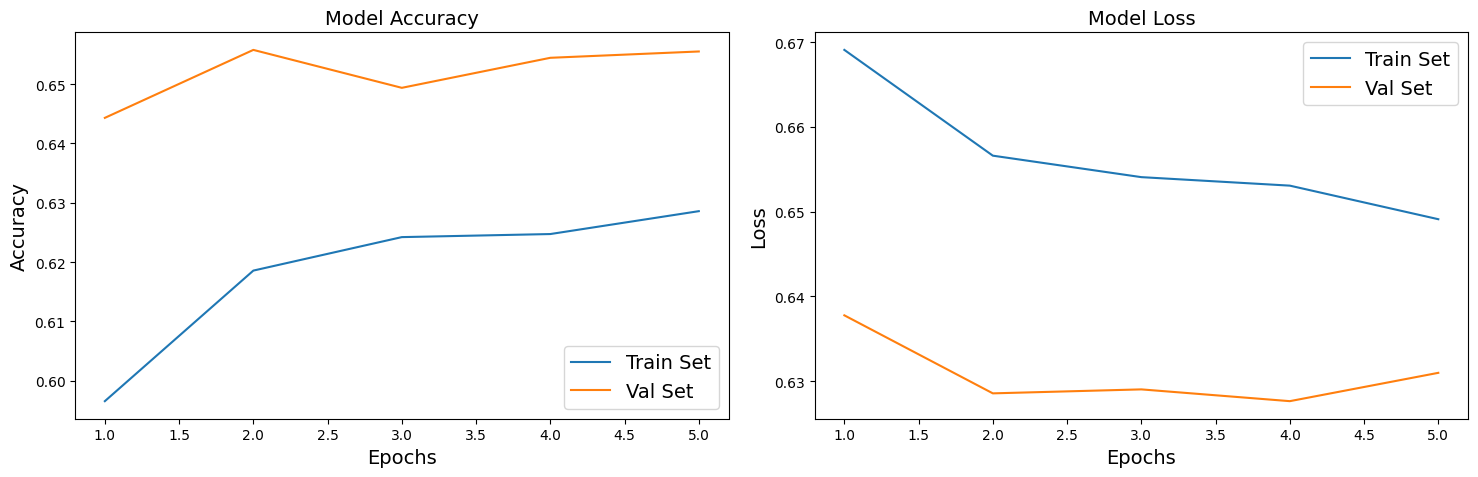

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
train_set_raw = train_ds
valid_set_raw = val_ds
test_set_raw  = test_ds

In [ ]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size_per_replica = 32
batch_size = batch_size_per_replica
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

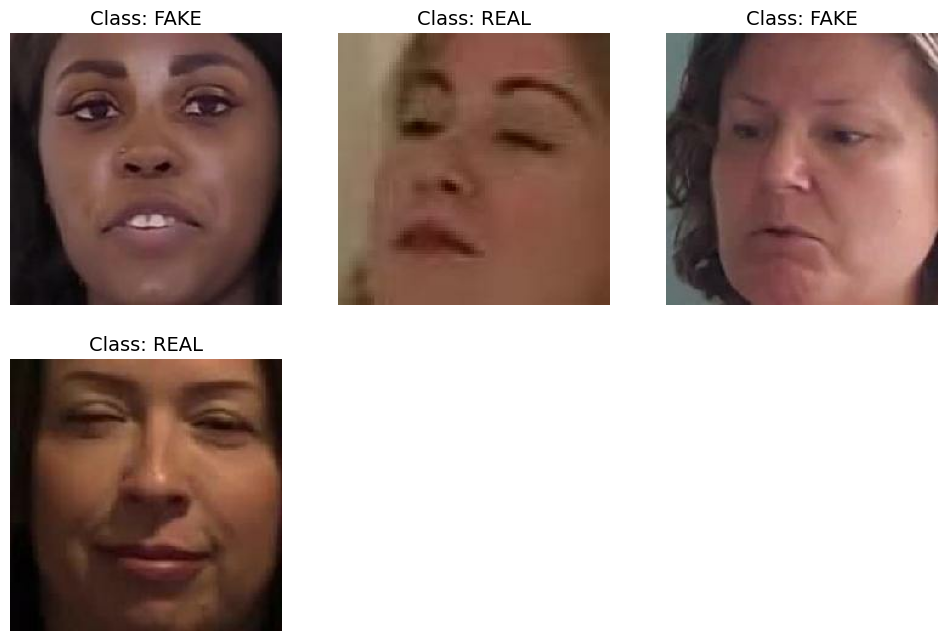

In [ ]:
import matplotlib.pyplot as plt

# Display up to the first 9 images from one batch of valid_set_raw
plt.figure(figsize=(12, 12))

for X_batch, y_batch in valid_set_raw.take(1):
    batch_size = X_batch.shape[0]            # e.g. 4 in your case
    n = min(9, batch_size)                   # don’t exceed available images
    for idx in range(n):
        plt.subplot(3, 3, idx + 1)
        img = X_batch[idx].numpy()
        plt.imshow(img)
        classt = 'FAKE' if int(y_batch[idx].numpy()) == 1 else 'REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()


In [ ]:
import tensorflow as tf

# Redefine augmentation to accept 4-D inputs
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")


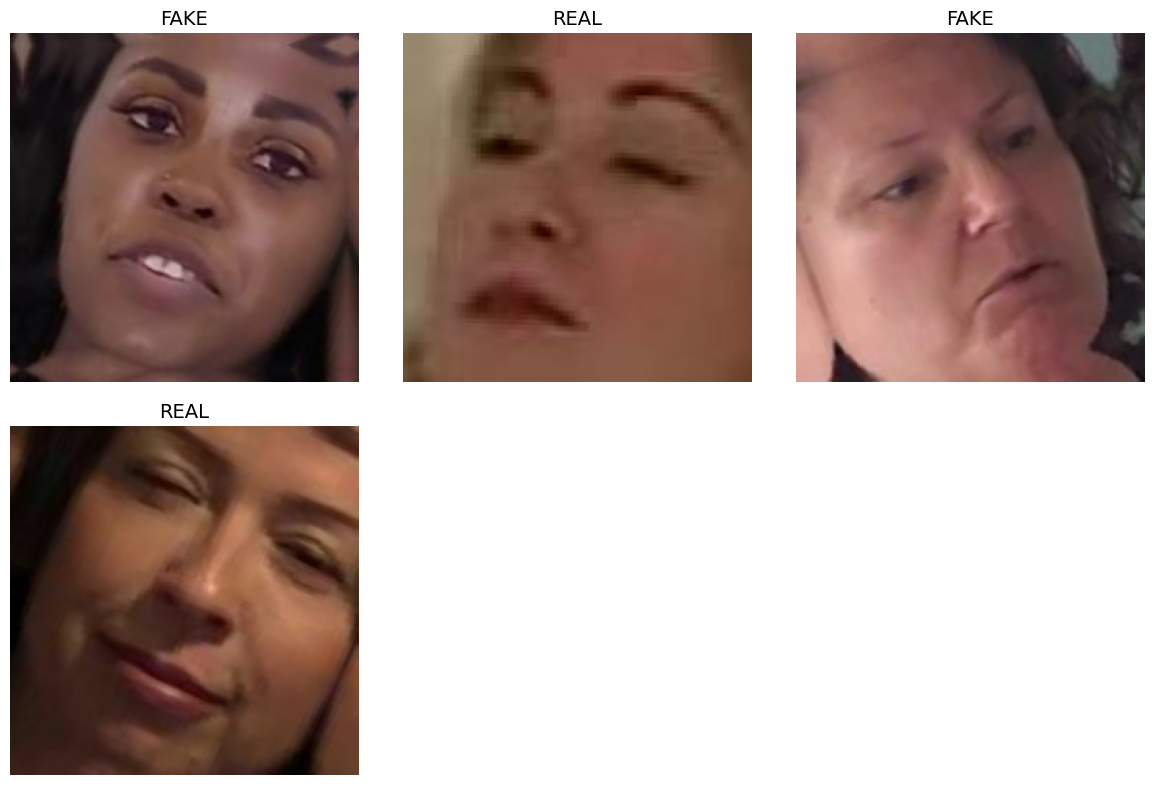

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))

# Grab one batch, augment it, and plot up to 9 images
for X_batch, y_batch in val_ds.take(1):
    # Now this will accept your 4-D batch
    X_aug = data_augmentation(X_batch, training=True)

    # Determine how many to plot
    batch_size = X_aug.shape[0]
    n = min(9, batch_size)

    for idx in range(n):
        ax = plt.subplot(3, 3, idx + 1)
        img = X_aug[idx].numpy()
        ax.imshow(np.clip(img, 0, 1))
        label = 'FAKE' if int(y_batch[idx].numpy()) == 1 else 'REAL'
        ax.set_title(label)
        ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:

# --- Updated: State-of-the-art Xception-based model ---
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Initialize base model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False

# Build and compile model
inputs = Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set_raw, validation_data=valid_set_raw, epochs=5, verbose=2)

Epoch 1/5
5320/5320 - 127s - 24ms/step - accuracy: 0.5463 - loss: 13.2839 - val_accuracy: 0.6012 - val_loss: 7.0364
Epoch 2/5
5320/5320 - 137s - 26ms/step - accuracy: 0.5583 - loss: 14.0901 - val_accuracy: 0.5682 - val_loss: 9.6943
Epoch 3/5
5320/5320 - 118s - 22ms/step - accuracy: 0.5598 - loss: 14.3603 - val_accuracy: 0.5942 - val_loss: 9.6034
Epoch 4/5
5320/5320 - 138s - 26ms/step - accuracy: 0.5642 - loss: 14.2939 - val_accuracy: 0.5945 - val_loss: 6.2134
Epoch 5/5
5320/5320 - 143s - 27ms/step - accuracy: 0.5657 - loss: 14.0244 - val_accuracy: 0.5953 - val_loss: 6.3453


In [ ]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_1          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [ ]:
results = model.evaluate(test_set_raw)

1565/1565 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.5931 - loss: 6.2782


In [ ]:
# Unfreeze from layer 56 onward
for layer in base_model.layers[56:]:
    layer.trainable = True

# Re‐compile with a lower learning rate for fine‐tuning
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

# Fine‐tune on the tf.data pipelines, not on numpy arrays
history = model.fit(
    train_ds,        # was train_set
    validation_data=val_ds,  # was valid_set
    epochs=10
)

Epoch 1/10
5320/5320 ━━━━━━━━━━━━━━━━━━━━ 260s 46ms/step - accuracy: 0.5359 - loss: 0.9006 - val_accuracy: 0.7220 - val_loss: 0.5910
Epoch 2/10
5320/5320 ━━━━━━━━━━━━━━━━━━━━ 247s 44ms/step - accuracy: 0.6788 - loss: 0.6122 - val_accuracy: 0.6403 - val_loss: 0.6715
Epoch 3/10
5320/5320 ━━━━━━━━━━━━━━━━━━━━ 238s 45ms/step - accuracy: 0.7453 - loss: 0.5292 - val_accuracy: 0.8099 - val_loss: 0.4353
Epoch 4/10
5320/5320 ━━━━━━━━━━━━━━━━━━━━ 259s 44ms/step - accuracy: 0.8074 - loss: 0.4373 - val_accuracy: 0.8099 - val_loss: 0.4218
Epoch 5/10
5320/5320 ━━━━━━━━━━━━━━━━━━━━ 234s 44ms/step - accuracy: 0.8544 - loss: 0.3411 - val_accuracy: 0.8347 - val_loss: 0.3787
Epoch 6/10
5320/5320 ━━━━━━━━━━━━━━━━━━━━ 262s 44ms/step - accuracy: 0.8899 - loss: 0.2686 - val_accuracy: 0.8078 - val_loss: 0.4898
Epoch 7/10
5320/5320 ━━━━━━━━━━━━━━━━━━━━ 266s 45ms/step - accuracy: 0.9196 - loss: 0.2096 - val_accuracy: 0.8371 - val_loss: 0.5663
Epoch 8/10
5320/5320 ━━━━━━━━━━━━━━━━━━━━ 259s 44ms/step - accuracy: 

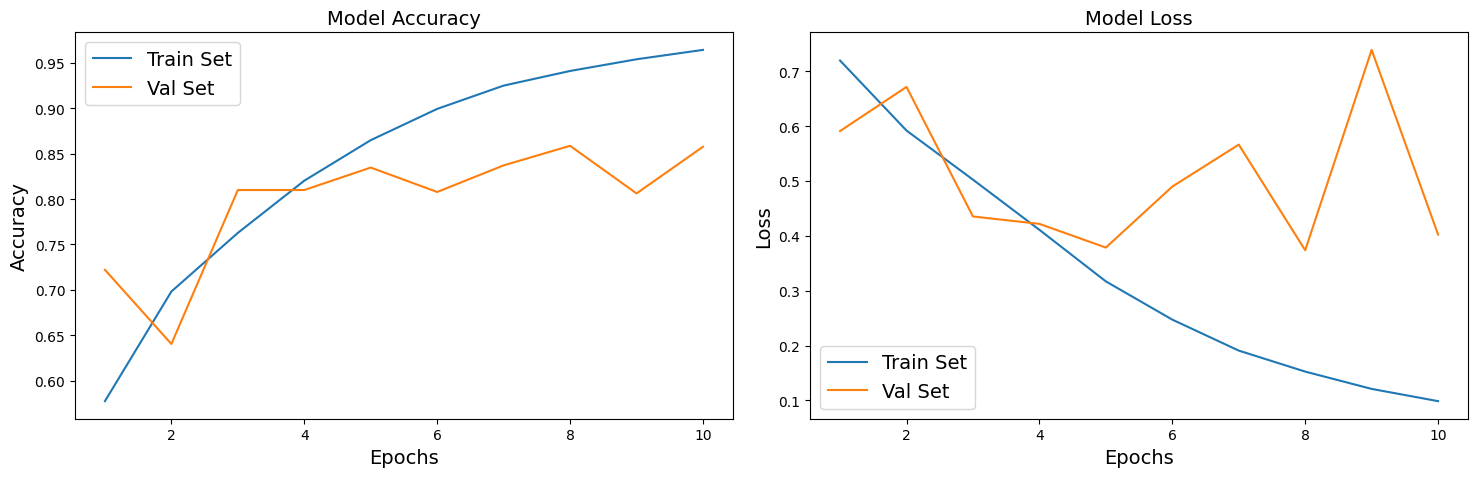

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
model.evaluate(test_ds)

1565/1565 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.8658 - loss: 0.3755


[0.36787763237953186, 0.8645151257514954]

In [ ]:
model.save('xception_deepfake_image_3o.h5')

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/275.7 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=eb67a36796ca319cf5150df105ab3e792e3362c45fb77b64169797339f5fc72b
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

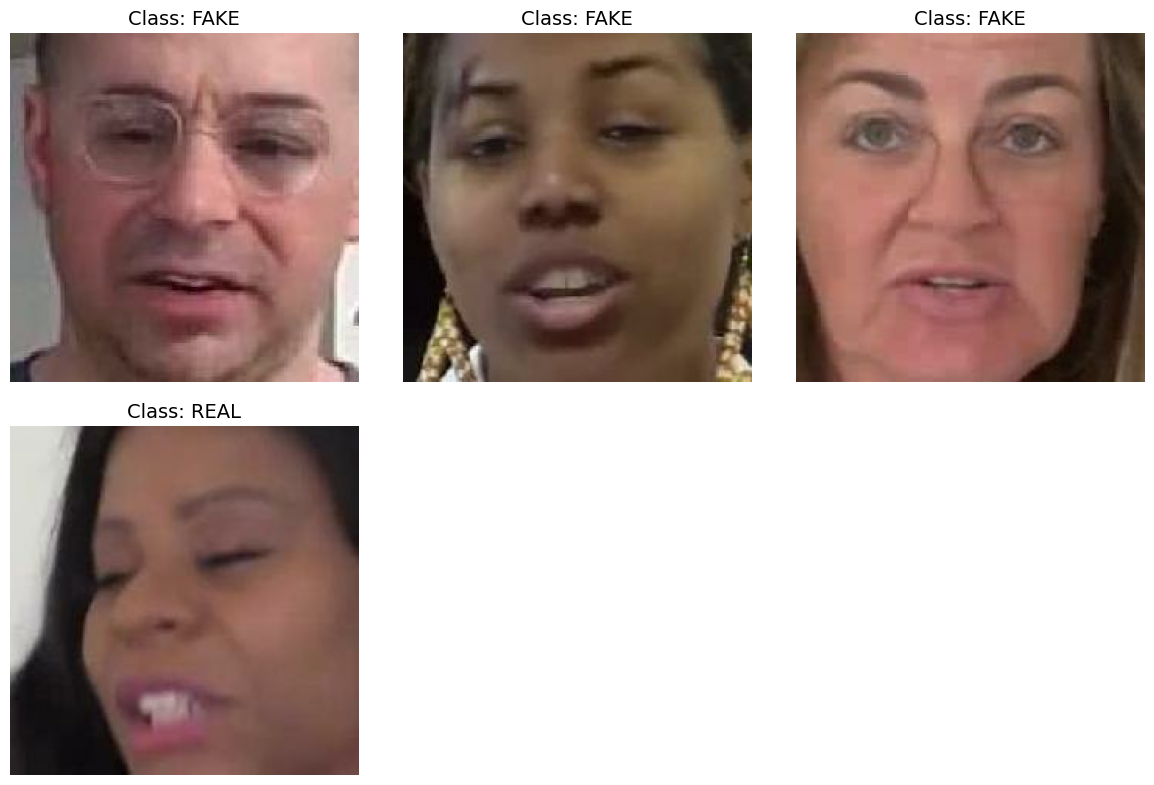

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))

# Take one batch from your test dataset
for X_batch, y_batch in test_ds.take(1):
    # How many images this batch actually has
    n = min(9, X_batch.shape[0])
    for idx in range(n):
        plt.subplot(3, 3, idx + 1)
        img = X_batch[idx].numpy()
        plt.imshow(np.clip(img, 0, 1))         # images are already [0,1]
        label = "FAKE" if int(y_batch[idx].numpy()) == 1 else "REAL"
        plt.title(f"Class: {label}")
        plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Grab the first batch from the test dataset
for X_batch, y_batch in test_ds.take(1):
    # X_batch is a Tensor of shape (batch_size, 224, 224, 3)
    test_data = X_batch[2]            # zero-based index: the 3rd image
    print("TensorShape:", test_data.shape)
    print("NumPy shape:", test_data.numpy().shape)
    break


TensorShape: (224, 224, 3)
NumPy shape: (224, 224, 3)


In [ ]:
# First convert your tensor to uint8 so LIME can work with it:
test_img_uint8 = (test_data.numpy() * 255).astype('uint8')

# Define a predict function that takes an array of images and returns the model's predictions
def predict_fn(images):
    images = tf.cast(images, tf.float32) / 255.0
    return model.predict(images)

# Then call explain_instance with your wrapped predict function:
explanation = explainer.explain_instance(
    test_img_uint8,
    predict_fn,
    top_labels=1, # Since it's binary classification, only predict probability for the positive class (1: FAKE)
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

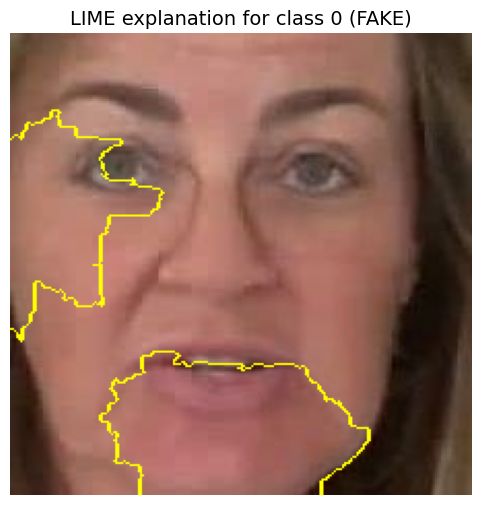

In [ ]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Get the mask for the top predicted label (FAKE)
label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=label,
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Overlay the mask on the original uint8 image
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(mark_boundaries(test_img_uint8, mask))
ax.set_title(f"LIME explanation for class {label} (FAKE)")
ax.axis("off")
plt.show()
